In [1]:
import xtrack as xt
import xobjects as xo
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [2]:
line = xt.Line.from_json('injection_lines/injection_thin_approx_ap_with_deferred_expressions.json')

Loading line from dict:   0%|          | 0/31362 [00:00<?, ?it/s]

Done loading line from dict.           


In [3]:
line['acl.31735'].frequency = 800e6
line['acl.31735'].voltage = 2 * 0.18e6
line['acl.31735'].lag = 180

line['actcse.31632'].frequency = 200e6
line['actcse.31632'].voltage = 4.5e6
line['actcse.31632'].lag = 180

In [4]:
num_turns = 1000
num_particles = 1000

nemitt_x = 3.5e-6
nemitt_y = 3.5e-6

In [5]:
#Check aperture
df_with_coll = line.check_aperture()

#OPtimize line and optics
line.build_tracker()
tw = line.twiss(method='4d')
line.collimators.assign_optics(twiss=tw, nemitt_x=nemitt_x, nemitt_y=nemitt_y)
line.optimize_for_tracking()

Checking aperture:   0%|          | 0/30210 [00:00<?, ?it/s]

Done checking aperture.           
0 thin elements miss associated aperture (upstream):
[]
0 thick elements miss associated aperture (upstream or downstream):
[]
Disable xdeps expressions
Replance slices with equivalent elements
Remove markers
Remove inactive multipoles
Merge consecutive multipoles
Remove redundant apertures
Remove zero length drifts
Merge consecutive drifts
Use simple bends
Use simple quadrupoles
Rebuild tracker data


In [6]:
x_norm = np.linspace(0, 15, num_particles)
px_norm = np.zeros_like(x_norm)
y_norm = np.zeros_like(x_norm)
py_norm = np.zeros_like(x_norm)
zeta = np.zeros_like(x_norm)
delta = np.zeros_like(x_norm)

part = line.build_particles(x_norm = x_norm, px_norm = px_norm, y_norm = y_norm, py_norm = py_norm, zeta = zeta, delta = delta, nemitt_x = nemitt_x, nemitt_y = nemitt_y)

In [7]:
monitor = xt.ParticlesMonitor(_context=line._context,
    num_particles=len(part.x),
    start_at_turn=0, # <-- first turn to monitor (including)
    stop_at_turn=num_turns, # <-- last turn to monitor (excluding)
)


line.discard_tracker()
line.insert_element(
    name="monitor", 
    element=monitor, 
    at=1
)
line.build_tracker(_context=xo.ContextCpu(omp_num_threads='auto'))

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [8]:
line.scattering.enable()
line.track(part, num_turns=num_turns, time=True, with_progress=1)
line.scattering.disable()

No xcoll elements found in line.


Tracking:   0%|          | 0/1000 [00:00<?, ?it/s]

No xcoll elements found in line.


/tmp/lpauwels/ipykernel_19512/1633871568.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


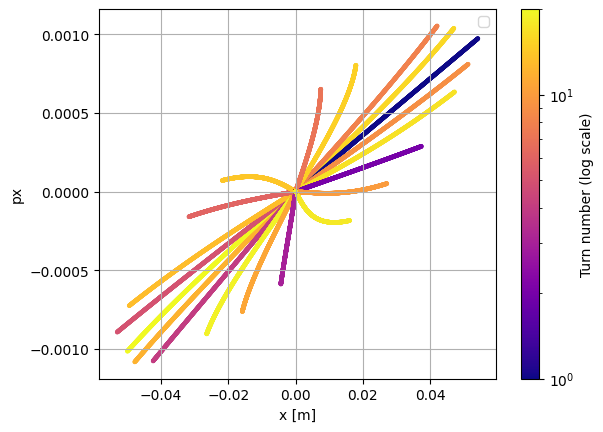

In [9]:
plt.figure()
max_turns = 20
for p in range(num_particles):
    scatter = plt.scatter(
        monitor.x[p, :max_turns], 
        monitor.px[p, :max_turns], 
        c=np.arange(1, max_turns + 1),  
        cmap='plasma',  
        norm=colors.LogNorm(vmin=1, vmax=max_turns), 
        s=5  
    )
plt.xlabel('x [m]')
plt.ylabel('px')
plt.grid()
plt.colorbar(label="Turn number (log scale)")
plt.legend()

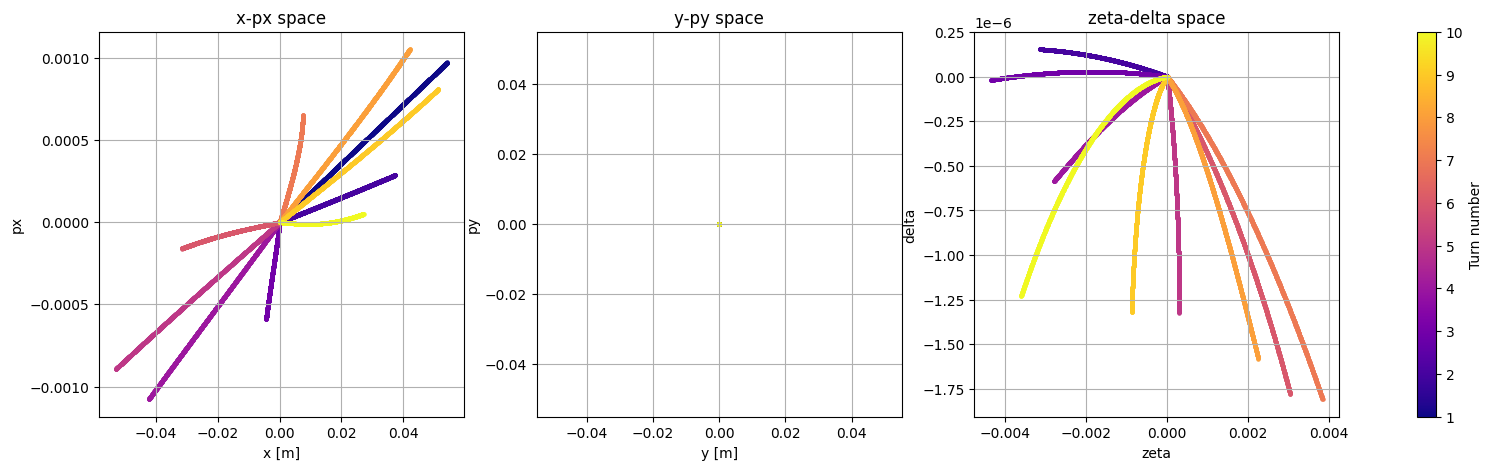

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

max_turns = 10

# Create the colormap
cmap = plt.get_cmap('plasma')
norm = colors.Normalize(vmin=1, vmax=max_turns)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Loop over turns and plot each one with the correct color
for turn in range(max_turns):
    color = cmap(norm(turn + 1))  # Color for each turn
    ax[0].scatter(monitor.x[:, turn], monitor.px[:, turn], color=color, marker='o', s=5)
    ax[1].scatter(monitor.y[:, turn], monitor.py[:, turn], color=color, marker='o', s=5)
    ax[2].scatter(monitor.zeta[:, turn], monitor.delta[:, turn], color=color, marker='o', s=5)

for axis in ax:
    axis.grid()

ax[0].set_xlabel('x [m]')
ax[0].set_ylabel('px')
ax[0].set_title('x-px space')
ax[1].set_xlabel('y [m]')
ax[1].set_ylabel('py')
ax[1].set_title('y-py space')
ax[2].set_xlabel('zeta')
ax[2].set_ylabel('delta')
ax[2].set_title('zeta-delta space')

# Add the colorbar
cbar = plt.colorbar(sm, ax=ax.ravel().tolist())
cbar.set_label("Turn number")

plt.show()

In [11]:
delta = np.linspace(0, 1e-3, num_particles)
x_norm = np.zeros_like(delta)
px_norm = np.zeros_like(delta)
y_norm = np.zeros_like(delta)
py_norm = np.zeros_like(delta)
zeta = np.zeros_like(delta)

part2 = line.build_particles(x_norm = x_norm, px_norm = px_norm, y_norm = y_norm, py_norm = py_norm, zeta = zeta, delta = delta, nemitt_x = nemitt_x, nemitt_y = nemitt_y)

In [12]:
monitor2 = xt.ParticlesMonitor(_context=line._context,
    num_particles=len(part2.x),
    start_at_turn=0, # <-- first turn to monitor (including)
    stop_at_turn=num_turns, # <-- last turn to monitor (excluding)
)


line.discard_tracker()
line.remove("monitor")
line.insert_element(
    name="monitor2", 
    element=monitor2, 
    at=1
)
line.build_tracker(_context=xo.ContextCpu(omp_num_threads='auto'))

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [13]:
line.scattering.enable()
line.track(part2, num_turns=num_turns, time=True, with_progress=1)
line.scattering.disable()

No xcoll elements found in line.


Tracking:   0%|          | 0/1000 [00:00<?, ?it/s]

No xcoll elements found in line.


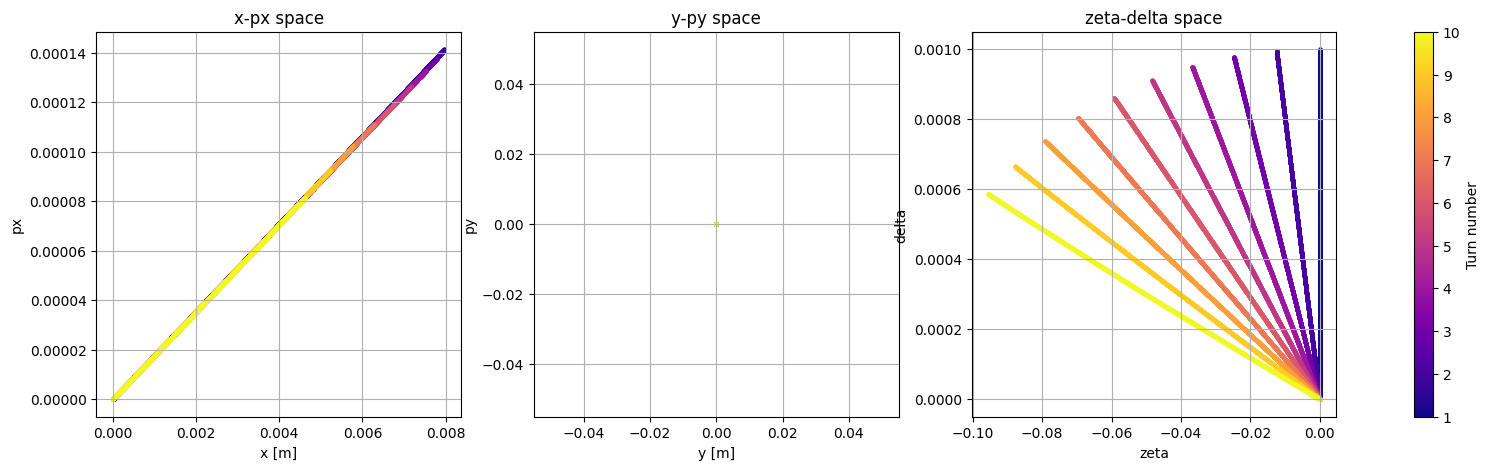

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

max_turns = 10

# Create the colormap
cmap = plt.get_cmap('plasma')
norm = colors.Normalize(vmin=1, vmax=max_turns)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Loop over turns and plot each one with the correct color
for turn in range(max_turns):
    color = cmap(norm(turn + 1))  # Color for each turn
    ax[0].scatter(monitor2.x[:, turn], monitor2.px[:, turn], color=color, marker='o', s=5)
    ax[1].scatter(monitor2.y[:, turn], monitor2.py[:, turn], color=color, marker='o', s=5)
    ax[2].scatter(monitor2.zeta[:, turn], monitor2.delta[:, turn], color=color, marker='o', s=5)

for axis in ax:
    axis.grid()

ax[0].set_xlabel('x [m]')
ax[0].set_ylabel('px')
ax[0].set_title('x-px space')
ax[1].set_xlabel('y [m]')
ax[1].set_ylabel('py')
ax[1].set_title('y-py space')
ax[2].set_xlabel('zeta')
ax[2].set_ylabel('delta')
ax[2].set_title('zeta-delta space')

# Add the colorbar
cbar = plt.colorbar(sm, ax=ax.ravel().tolist())
cbar.set_label("Turn number")

plt.show()